# <font color='navy'> Exploratory Analyses of SPACs in the U.S. </font>


#### <font color='grey'> Source of data: SEC Filings, Boomberg, Citi Research</font>
#### <font color='grey'> Date: March 24, 2019 </font>

In [8]:
import hide_code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import BDay
from IPython.display import Markdown
import warnings

warnings.filterwarnings('ignore')
output_path = "C:/Users/Jenian/Documents/Research Library/Data Science/Projects/181021 - US SPACs"
lastdate = "2019-3-8"
start_yr = 2009
round_int = 1 
ipopx = 10

def printmd(string):
    display(Markdown(string))

def perct(s):
    s = s.apply("{0:.1%}".format)
    return s

def stat(col,idx):
    result = perct(col.quantile([0,.25, .5, .75,1]))
    avg = perct(pd.Series(np.mean(col)))
    count = pd.Series(len(col))
    result = count.append([avg,result])
    result.index = ['No. of Obs', 'Mean', "Min", "1Q", "Median", "3Q", 'Max']
    result = pd.DataFrame(result).T
    result.index = [idx]
    return result

dealdata = pd.read_excel(output_path + '/us_spac_list.xlsx', 'Sheet1')
pxdata = pd.read_csv(output_path + '/us_spac_data_hc.csv', low_memory=False)
# remove irrelvant row
pxdata = pxdata.drop(0)

# Filter valid deals with at least 200M offer size on or after 2009
fil_deal = dealdata[(dealdata['Included'] == 'v') & (dealdata['Year'] >= start_yr)]

# with deal announcement happened
announced = fil_deal[fil_deal['M&A'] == 'y']
# Remove unnecessary column from dealdata
announced = announced[["Pricing Date", "Revised Ticker","Offer Size (M)", 
                       "Bookrunner", "AnnounceDate","CompleteDate", 
                       "Sector", "M&AFail"]].reset_index(drop=True)
# for deals that haven't completed, use the latest price
announced["CompleteDate"].fillna(pd.to_datetime(lastdate), inplace = True)

# feature engineering
## create M&A period return column
### create additional new columns
announced = pd.concat([announced,pd.DataFrame(columns=["announcepx", "completepx"])])
ticker = announced['Revised Ticker']
### find prices at deal announcement and completion
for i in range(0,len(announced)):
    filename = output_path + "/Data/" + ticker[i] + " US.csv"
    current_data = pd.read_csv(filename, parse_dates=["Date"])
    announce_date = announced['AnnounceDate'][i]
    complete_date = announced['CompleteDate'][i]
    a = current_data[current_data["Date"] == announce_date].index[0]
    c = current_data[current_data["Date"] == complete_date].index[0]
    announced['announcepx'][i] = current_data.iloc[a,1]
    announced['completepx'][i] = current_data.iloc[c,1]

### create return variable
announced["M&ARtn"] = announced['completepx']/announced['announcepx']-1

## create date variables
announced['announce_mo'] = announced['AnnounceDate'].dt.month
### Monday=0, Sunday=6
announced['announce_dow'] = announced['AnnounceDate'].dt.dayofweek
announced['announce_yr'] = announced['AnnounceDate'].dt.year
announced["time_to_announce"] = (announced['AnnounceDate'] - announced['Pricing Date']).dt.days
announced["time_to_complete"] = (announced['CompleteDate'] - announced['AnnounceDate']).dt.days
announced['complete_mo'] = announced['CompleteDate'].dt.month
announced['complete_dow'] = announced['CompleteDate'].dt.dayofweek
announced['complete_yr'] = announced['CompleteDate'].dt.year

## create broker variables
### split strings by comma into list
announced["Bookrunner"] = announced["Bookrunner"].str.lower().str.split(", ")
### create dummy variables 
dum = announced["Bookrunner"].str.join(sep=',').str.get_dummies(sep=',')
dum.columns = ['B. Riley','BAML', 'BMO', 'Cantor', 'Citi', 'Credit Suisse',
                      'Deutsche', 'EarlyBird', 'FBR', 'Goldman', 'Jefferies',
                      'Maxim', 'National Bank', 'Stifel', 'UBS']

nodeal = fil_deal[fil_deal['M&A'] == 'n']
nodeal["Bookrunner"] = nodeal["Bookrunner"].str.lower().str.split(", ")
dum2 = nodeal["Bookrunner"].str.join(sep=',').str.get_dummies(sep=',')
dum2.columns = ['BAML', 'Cantor', 'Chardan', 'Citi', 'Cowen', 'Credit Suisse',
                'Deutsche', 'EarlyBird', 'FBR', 'Goldman', 'Jefferies', 'JPMorgan',
                'Macquarie', 'Morgan Stanley', 'Oppenheimer', 'RBC', 'Stifel',
                'UBS', 'Wells Fargo']

a = dum.sum()
b = dum2.sum()
c = a.add(b, fill_value=0)
c = pd.concat([c,a], axis = 1).fillna(0)

combine = pd.concat([announced, dum], axis = 1)

# filter successful deals
combine_success = combine[(combine['M&AFail'] == 'n')].reset_index(drop=True)
combine_failure = combine[(combine['M&AFail'] == 'y')]
### create normalize price history of M&A period
ticker_success = combine_success['Revised Ticker']
result = pd.DataFrame()
unnormresult = pd.DataFrame()
for i in range(0,len(combine_success)):
    filename = output_path + "/Data/" + ticker_success[i] + " US.csv"
    current_data = pd.read_csv(filename, parse_dates=["Date"]).set_index("Date")
    announce_date = combine_success['AnnounceDate'][i]
    complete_date = combine_success['CompleteDate'][i]
    timeseries = current_data.loc[announce_date:complete_date, 'Close'].reset_index(drop=True)
    unnormresult = pd.concat([unnormresult, timeseries], axis=1)
    result = pd.concat([result, timeseries/timeseries[0]-1], axis = 1)
result.columns = ticker_success
unnormresult.columns = ticker_success

complete_time = round(combine_success['time_to_complete'].mean()/30, round_int)
hunt_time = round(combine_success['time_to_announce'].mean()/30, round_int)

clean_fil_deal = fil_deal[pd.notnull(fil_deal['Revised Ticker'])].reset_index(drop=True)
clean_ticker = clean_fil_deal['Revised Ticker'].unique()
resultall = pd.DataFrame()
endpx = pd.Series()
for i in range(0,len(clean_ticker)):
    filename = output_path + "/Data/" + clean_ticker[i] + " US.csv"
    current_data = pd.read_csv(filename, parse_dates=["Date"]).set_index("Date")[['Close']]
    px = current_data.loc[current_data.last_valid_index(),'Close']
    current_data.rename(columns = {'Close':clean_ticker[i]}, inplace = True)
    endpx = endpx.append(pd.Series(px))
    resultall = resultall.join(current_data, how = "outer")
    
resultall = resultall/ipopx-1

bd_before_ann = 20
result1m = pd.DataFrame()
for i in range(0,len(combine)):
    filename = output_path + "/Data/" + ticker[i] + " US.csv"
    current_data = pd.read_csv(filename, parse_dates=["Date"]).set_index("Date")
    bgn_date = combine['AnnounceDate'][i] - BDay(bd_before_ann)
    end_date = combine['AnnounceDate'][i]
    timeseries = current_data.loc[bgn_date:end_date, 'Close'].reset_index(drop=True)
    result1m = pd.concat([result1m, timeseries/timeseries[0]-1], axis = 1)
result1m.columns = ticker

## risk reward
pos_prob = sum(combine_success['M&ARtn']>= 0.02)/len(combine_success)
neg_prob = 1-pos_prob
avg_pos_ret = combine_success[combine_success['M&ARtn']>= 0.02]['M&ARtn'].mean()
avg_neg_ret = combine_success[combine_success['M&ARtn']< 0.02]['M&ARtn'].mean()
risk_reward = (avg_pos_ret*pos_prob)/(avg_neg_ret*neg_prob)

## weight returns
totalsize = combine_success[['Offer Size (M)']].sum()[0]
combine_success['w_rtn'] = combine_success['M&ARtn']*(combine_success['Offer Size (M)']/totalsize)
w_pos_ret = combine_success[combine_success['M&ARtn']>= 0.02]['w_rtn'].sum()
w_neg_ret = combine_success[combine_success['M&ARtn']< 0.02]['w_rtn'].sum()
w_risk_reward = (w_pos_ret*pos_prob)/(w_neg_ret*neg_prob)

## 3 variables comparison of top six banks
bank = pd.melt(combine, id_vars=['announce_yr', 'M&ARtn'], value_vars=['Citi', 'Deutsche', 'Credit Suisse', 'Goldman', 'BAML', 'Cantor'])
bank = bank[bank['value']==1]

## <font color='royalblue'>"If you spend your energies looking for and analyzing situations not closely followed by other investors, your chance of finding bargains greatly increases" - Joel Greenblatt</font>

In [6]:
printmd('A SPAC is a public pool of capital formed with the intention of identifying an operating business to acquire. The target business has to be valued at least 80 percent of the cash in the SPAC.'+
        ' Almost all the funds raised by the SPAC are placed in an interest-bearing trust account that cannot be disbursed other than for the closing of an acquisition or share redemptions.')
        
printmd('Every SPAC has warrants, which are essentially long-dated options on the success of the acquisition strategy. At a typical SPAC IPO, the public investors are sold units, each comprised of '+'**one share**'+' of common stock and usually up to '+ '**a half warrant**'+ '. If the SPAC transaction does not occur within a specified timeframe, commonly two years, the warrants expire worthless.  The vehicle will be liquidated, and the investors are returned pro rata share of the cash in the trust account, including interest earned over the period but less certain expenses.')

printmd("If the transaction does occur, the warrant can still expire worthless if the company's shares do not surpass a pre-determined strike price (typically $11.50 per share) within the next few years. However, these warrants provide the possibility of levered upside. If the SPAC successfully identifies an operating company and is able to improve operations over the subsequent five years, the upside to the warrants can be substantial. In some cases, the warrants are acquired by the company prior to expiration.")

A SPAC is a public pool of capital formed with the intention of identifying an operating business to acquire. The target business has to be valued at least 80 percent of the cash in the SPAC. Almost all the funds raised by the SPAC are placed in an interest-bearing trust account that cannot be disbursed other than for the closing of an acquisition or share redemptions.

Every SPAC has warrants, which are essentially long-dated options on the success of the acquisition strategy. At a typical SPAC IPO, the public investors are sold units, each comprised of **one share** of common stock and usually up to **a half warrant**. If the SPAC transaction does not occur within a specified timeframe, commonly two years, the warrants expire worthless.  The vehicle will be liquidated, and the investors are returned pro rata share of the cash in the trust account, including interest earned over the period but less certain expenses.

If the transaction does occur, the warrant can still expire worthless if the company's shares do not surpass a pre-determined strike price (typically $11.50 per share) within the next few years. However, these warrants provide the possibility of levered upside. If the SPAC successfully identifies an operating company and is able to improve operations over the subsequent five years, the upside to the warrants can be substantial. In some cases, the warrants are acquired by the company prior to expiration.

## <font color='navy'>Now, let's see some of our interesting studies - </font>
### <font color='navy'>The chart below shows all SPACs' transaction period (from announcement date to completion date) performance since 2009</font>

In [7]:
printmd('Our research covered 32 successful transactions with '+'**initial market cap over US$200m**'+' in the US market since '+'**2009**'+'.'+
        ' The reason we filtered out smaller SPACs was because of the lack of scale and quality assets at low price, and their poor investibility by asset managers.')
printmd('Historically, the average time taken for management to find acquisition target was about ' + str(hunt_time) + ' months. The average time taken for them to close a deal was about ' + str(complete_time) + ' months.')
printmd("While the overall average return was uninspiring, the reason was because many of the SPACs were not reacting to the transaction announcements.") 
stat(combine_success['M&ARtn'],'Transaction Period Return')

Our research covered 32 successful transactions with **initial market cap over US$200m** in the US market since **2009**. The reason we filtered out smaller SPACs was because of the lack of scale and quality assets at low price, and their poor investibility by asset managers.

Historically, the average time taken for management to find acquisition target was about 14.9 months. The average time taken for them to close a deal was about 4.2 months.

While the overall average return was uninspiring, the reason was because many of the SPACs were not reacting to the transaction announcements.

,No. of Obs,Mean,Min,1Q,Median,3Q,Max
Transaction Period Return,32,3.9%,-20.2%,-0.7%,1.7%,6.7%,61.8%


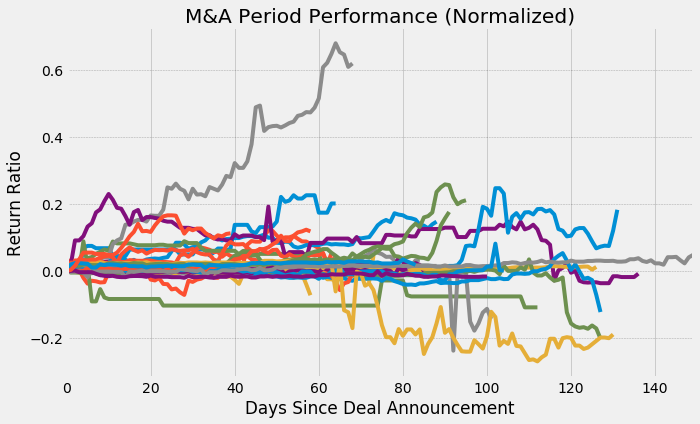

In my opinion, having lots of flat performance that dragged the average isn't as bad as if there are some big losers. If we classify the observations into two classes based on a 2% threshold of return and recalculate the statistics by each class, however, we see a compelling story.

The average return and probability of the group with 2% or higher return was 13.7% and 46.9%, whilst those of the other group with less than 2% return was -4.7% and 53.1%, respectively. The period when transactions were happening had an outsized **probability-adjusted risk/reward** of 2.56x. Or more simply put, the downside is very limited investing from the transaction announcement.

Moreover, the chance that a deal was withdrawn was low at 5.9%. In the worst case, you just get your money back..

,No. of Obs,Mean,Min,1Q,Median,3Q,Max
Return of Withdrawn Deals,2,1.2%,0.0%,0.6%,1.2%,1.8%,2.4%


In [9]:
result.plot(figsize=(10, 6),legend=None,title = "M&A Period Performance (Normalized)")
plt.style.use('fivethirtyeight')
plt.xlabel('Days Since Deal Announcement')
plt.ylabel('Return Ratio')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.show()

printmd("In my opinion, having lots of flat performance that dragged the average isn't as bad as if there are some big losers. If we classify the observations into two classes based on a 2% threshold of return and recalculate the statistics by each class, however, we see a compelling story.")
printmd('The average return and probability of the group with 2% or higher return was '+"{0:.1%}".format(avg_pos_ret)+ ' and '+"{0:.1%}".format(pos_prob)+', whilst those of the other group with less than 2% return was '+ "{0:.1%}".format(avg_neg_ret)+ ' and '+"{0:.1%}".format(neg_prob)+', respectively. The period when transactions were happening had an outsized '+'**probability-adjusted risk/reward**'+' of '+ str(round(abs(risk_reward), 2))+'x. Or more simply put, the downside is very limited investing from the transaction announcement.')
printmd('Moreover, the chance that a deal was withdrawn was low at ' + "{0:.1%}".format(sum(announced['M&AFail'] == 'y')/len(announced)) 
      + '. In the worst case, you just get your money back..')
stat(combine_failure['M&ARtn'],'Return of Withdrawn Deals')

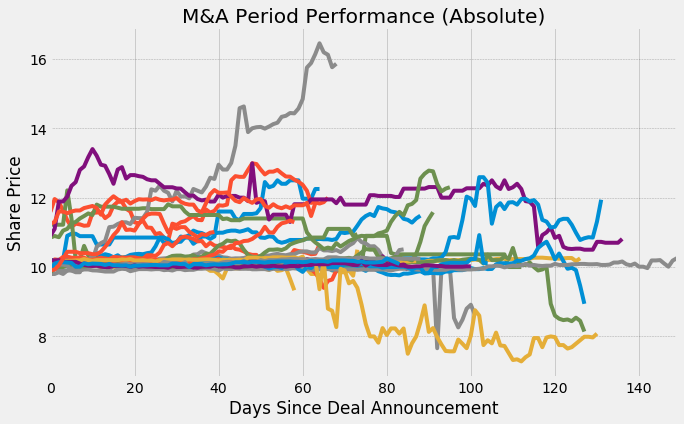

Because of the downside protection to investors through share redemption, it's **unlikely to lose a considerable amount** if we buy the shares around $10 per share on the transaction announcement date. Losses in previous chart were partially attributable to already elevated prices of SPACs on announcement dates.

In [10]:
unnormresult.plot(figsize=(10, 6),legend=None,title = "M&A Period Performance (Absolute)")
plt.style.use('fivethirtyeight')
plt.xlabel('Days Since Deal Announcement')
plt.ylabel('Share Price')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.show()

printmd("Because of the downside protection to investors through share redemption, it's "+'**unlikely to lose a considerable amount**'+" if we buy the shares around $10 per share on the transaction announcement date. Losses in previous chart were partially attributable to already elevated prices of SPACs on announcement dates.")

### <font color='navy'>The next question we want to explore is the size effect
</font>

In [11]:
printmd("We assigned a weight to each SPAC's transaction period return by multiplying the periodic return to the IPO size ratio, "+
        'which is the offer size relative to the remaining 31 candidates in the above study. After that, we sliced the 32 shares by weighted periodic return based on the 2% return threshold. '+
        'Unsurprisingly, the weighted return of the group with 2% or higher return was '+"{0:.1%}".format(w_pos_ret)+ '; more than double the weighted loss for the group with less than 2% return, which was '+ "{0:.1%}".format(w_neg_ret)+
        '. The probability-adjusted risk/reward in this case was '+str(round(abs(w_risk_reward), 2))+'x.')
printmd('The weighted risk/reward was still attracitve, but it came down from our unweighted measure. It seems that the larger deals may not always be the better.')

We assigned a weight to each SPAC's transaction period return by multiplying the periodic return to the IPO size ratio, which is the offer size relative to the remaining 31 candidates in the above study. After that, we sliced the 32 shares by weighted periodic return based on the 2% return threshold. Unsurprisingly, the weighted return of the group with 2% or higher return was 6.9%; more than double the weighted loss for the group with less than 2% return, which was -3.0%. The probability-adjusted risk/reward in this case was 2.02x.

The weighted risk/reward was still attracitve, but it came down from our unweighted measure. It seems that the larger deals may not always be the better.

### <font color='navy'>Why would a company choose to be acquired by a SPAC versus going public in an official IPO?</font>

There are a few reasons to it:

1) In certain sectors such as oil and gas, its financing window was closed since the oil crises in 2008 and 2014. For instance in 2016, Freeport cancelled its IPO plan for oil and gas business. For the capital intensive industry to reduce debt in such volatile and uncertain market environment, a SPAC is a viable option.

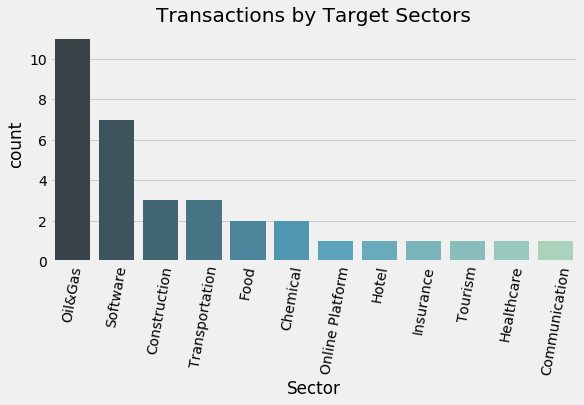

In [12]:
printmd('There are a few reasons to it:')
printmd("1) In certain sectors such as oil and gas, its financing window was closed since the oil crises in 2008 and 2014."+
        ' For instance in 2016, Freeport cancelled its IPO plan for oil and gas business. For the capital intensive industry'+
        ' to reduce debt in such volatile and uncertain market environment, a SPAC is a viable option.')
sns.countplot(x = "Sector", data = announced, palette="GnBu_d", order = announced["Sector"].value_counts().index)
plt.style.use('fivethirtyeight')
plt.subplots_adjust(right=1.3)
plt.title('Transactions by Target Sectors')
plt.xticks(rotation=80) 
plt.show()

In [296]:
printmd('2) When a company gets acquired by a SPAC, they go public without paying for all the fees and underwriting costs. The costs are covered by the SPAC before the target company ever gets involved.')
printmd('3) Often target companies are not regularly preparing financial statements that meet SEC filing requirements or being audited under the standards of the Public Company Accounting'+
        ' Oversight Board. Through business combination, these private companies are subject to fewer Exchange Act reporting requirements of historical performance relative to a formal IPO.')

2) When a company gets acquired by a SPAC, they go public without paying for all the fees and underwriting costs. The costs are covered by the SPAC before the target company ever gets involved.

3) Often target companies are not regularly preparing financial statements that meet SEC filing requirements or being audited under the standards of the Public Company Accounting Oversight Board. Through business combination, these private companies are subject to fewer Exchange Act reporting requirements of historical performance relative to a formal IPO.

###  <font color='navy'>Wrapping up the event trade</font>

Looking back 20 business days before the transaction announcements, we didn't see any preemptive move in any of the shares. In other words, there is no urge to get in ahead of the announcements. According to the statistics above, we can make money by just buying on the deal announcement day.

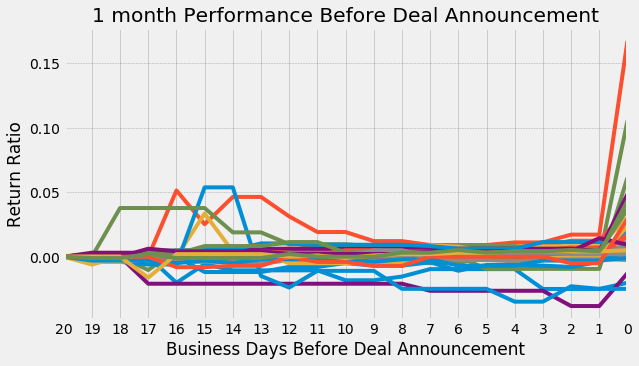

In [13]:
printmd("Looking back 20 business days before the transaction announcements, we didn't see any preemptive move in any of the shares. In other words, there is no urge to get in ahead of the announcements. According to the statistics above, we can make money by just buying on the deal announcement day.")

ax = result1m.plot(figsize=(9, 5),legend=None,title = "1 month Performance Before Deal Announcement")
ax.set_xticks(range(len(result1m)))
ax.set_xticklabels(np.arange(len(result1m)-1, -1, -1))
plt.style.use('fivethirtyeight')
plt.xlabel('Business Days Before Deal Announcement')
plt.ylabel('Return Ratio')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.show()

### <font color='navy'>Back up</font>

What have happened to SPACs since 2009? After the oil crises, SPACs had moved from the avenue of last resort for companies that want to go public but can't, to the only resort for those companies. Also, private equity funds joined the game and treat SPAC as one of their exit strategies due to cautious senitment in the public equity market. (See recent IPO Alight "ALIT US" which was dropped due to overleveraged balance sheet and lack of investor interest.)

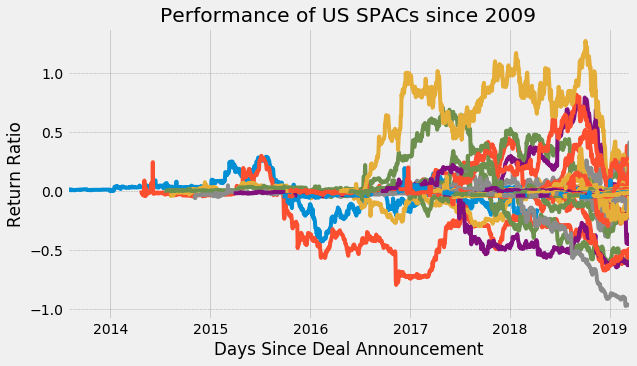

The statistics for all SPACs is worse than the periodic return above because it includes many SPACs that failed to identify and secure target acquisitions within the two-year period

,No. of Obs,Mean,Min,1Q,Median,3Q,Max
Return of all SPACs Since IPO,63,-3.8%,-97.2%,-1.3%,0.2%,2.2%,38.6%


In [19]:
printmd("What have happened to SPACs since 2009? After the oil crises, SPACs had moved from the avenue of last resort"+
        " for companies that want to go public but can't, to the only resort for those companies. Also, private equity funds"+
        ' joined the game and treat SPAC as one of their exit strategies due to cautious senitment in the public equity market. (See recent IPO Alight "ALIT US" which was dropped due to overleveraged balance sheet and lack of investor interest.)')

resultall.plot(figsize=(9, 5),legend=None,title = "Performance of US SPACs since "+ str(start_yr))
plt.xlabel('Days Since Deal Announcement')
plt.ylabel('Return Ratio')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.show()
print('')
printmd("The statistics for all SPACs is worse than the periodic return above because it includes many SPACs that failed to identify and secure"+
       ' target acquisitions within the two-year period')

stat(endpx/ipopx-1,'Return of all SPACs Since IPO')

### <font color='navy'>Which banks are active in SPACs?</font>

**Deutsche Bank**, the German global investment bank, is ranked the most active managers of SPACs by count of total listings, followed by **Citi**, the US banking giant.

The following table gives a summary of listings by various investment banks, with the red category being the number of SPACs that had annouced acquisitions.

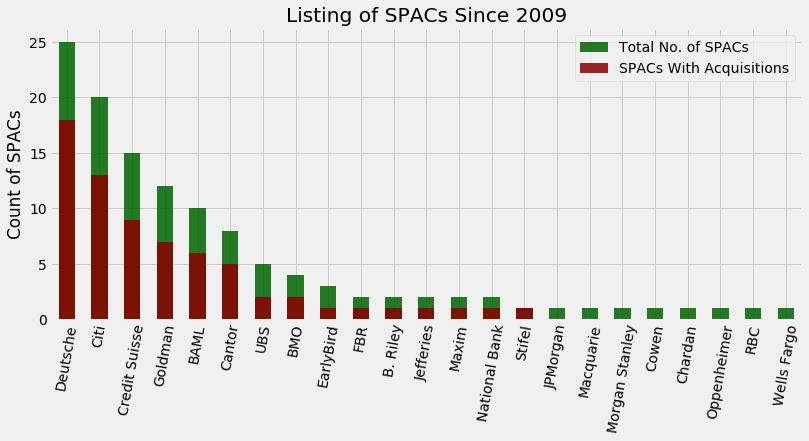

In [15]:
printmd('**Deutsche Bank**'+', the German global investment bank, is ranked the most active managers of SPACs by count of total listings,'+
        ' followed by '+'**Citi**'+', the US banking giant.')
printmd('The following table gives a summary of listings by various investment banks, with the red category being the number of SPACs that had annouced acquisitions.')
c[0].sort_values(ascending=False).plot.bar(figsize=(12, 5), color = 'darkgreen', alpha = 0.85)
c[1].sort_values(ascending=False).plot.bar(figsize=(12, 5), color = 'darkred', alpha = 0.85)
plt.title('Listing of SPACs Since 2009')
plt.legend(('Total No. of SPACs', 'SPACs With Acquisitions'), loc='upper right')
plt.ylabel('Count of SPACs')
plt.xticks(rotation=80) 
plt.show()

In [16]:
printmd('Since we are interested in the events i.e. when the SPACs announce their transactions, let us focus on the red part of the bars. We know these events may provide asymmetric payoff, and we want to see if there was a pattern there with regards to the year, return and sponsor. In the chart below, we pick the top six active sponsors, namely Deutsche Bank, Citi, Goldman Sachs, Bank of America Merrill Lynch, and Cantor Fitzgerald for analysis.')

Since we are interested in the events i.e. when the SPACs announce their transactions, let us focus on the red part of the bars. We know these events may provide asymmetric payoff, and we want to see if there was a pattern there with regards to the year, return and sponsor. In the chart below, we pick the top six active sponsors, namely Deutsche Bank, Citi, Goldman Sachs, Bank of America Merrill Lynch, and Cantor Fitzgerald for analysis.

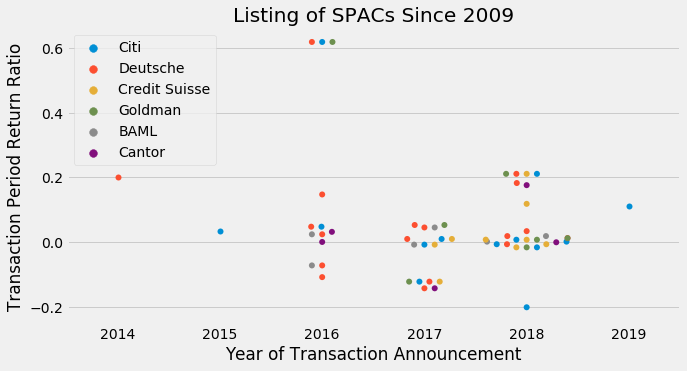

Interestingly, some fantastic returns happened back in 2016, but they have come down to around 20% in recent years. Nevertheless, there are only a handful of SPAC transactions that happened in the past, and they are not sufficient to form a statistical conclusion.

In [17]:
sns.swarmplot(x="announce_yr", y="M&ARtn", hue="variable", data=bank, size=6)
plt.title('Listing of SPACs Since 2009')
plt.xlabel('Year of Transaction Announcement')
plt.ylabel('Transaction Period Return Ratio')
plt.subplots_adjust(right=1.5,top = 1.1)
plt.legend(loc='upper left')
plt.show() 
printmd('Interestingly, some fantastic returns happened back in 2016, but they have come down to around 20% in recent years. Nevertheless, there are only a handful of SPAC transactions that happened in the past, and they are not sufficient to form a statistical conclusion.')

### SPACs are an interesting hunting ground for alpha because there are some protections for the investors, there is little sell-side research, and historically there have been some large winners. If you would like to learn more about my research, feel free to get in touch. 

### Thank you for reading.

### Jenian